<a href="https://colab.research.google.com/github/guidomoor/FEA-ML/blob/main/U_RF_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RF Prediction from U**

the dataframe is extracted from single element simulations where one node is being displaced (u1,u2). The element is a 2D plain strain element fully integrated:

4--------3

1--------2

U is a 8x8 array = [u11, u12, u21, u22, ..., u44]
RF is a 8x8 array = [RF11, RF12, ..., RF44]

In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [92]:
 #Create a model that inherits nn.Module
 class Model(nn.Module):
  #Input Layer (4 features of flower) -->
  #Hidden Layer 1 (#of neurons) -->
  #H2 --> Output
  #(3 classes of flowers)
  def __init__(self, in_features=8, h1=16, h2=32, h3=16, out_features=8):
    super().__init__()
    self.fc1 = nn.Linear(in_features, h1)
    self.fc2 = nn.Linear(h1, h2)
    self.fc3 = nn.Linear(h2, h3)
    self.out = nn.Linear(h3, out_features)

  #this function is pushing the information forward through the layers
  def forward(self, x):
    x = F.relu(self.fc1(x)) #rectify linear unit function relu
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.out(x)
    return x

In [93]:
torch.manual_seed(42)
model = Model()

In [94]:
from google.colab import files

# Upload a file
uploaded = files.upload()

# Check the uploaded files
for filename in uploaded.keys():
    print(f'Uploaded file: {filename}')
    my_df = pd.read_csv(filename, header=None)  # Read the CSV file into a DataFrame


Saving my_df.csv to my_df (5).csv
Uploaded file: my_df (5).csv


In [95]:
my_df


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.0000,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000
1,0.01,7.612179e-34,-4.407051e-34,9.214743e-34,-6.009615e-34,-1.201923e-34,1.201923e-34,6.009615e-34,1241.9872,-761.21796,440.70514,-921.47437,600.96155,120.19231,-120.19231,-600.96155
2,0.02,1.522436e-33,-8.814103e-34,1.842949e-33,-1.201923e-33,-2.403846e-34,2.403846e-34,1.201923e-33,2483.9744,-1522.43590,881.41030,-1842.94870,1201.92310,240.38461,-240.38461,-1201.92310
3,0.03,2.283654e-33,-1.322115e-33,2.764423e-33,-1.802885e-33,-3.605769e-34,3.605769e-34,1.802885e-33,3725.9614,-2283.65380,1322.11540,-2764.42300,1802.88460,360.57693,-360.57693,-1802.88460
4,0.04,3.044872e-33,-1.762821e-33,3.685897e-33,-2.403846e-33,-4.807693e-34,4.807693e-34,2.403846e-33,4967.9487,-3044.87180,1762.82060,-3685.89750,2403.84620,480.76923,-480.76923,-2403.84620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,0.26,2.339744e-32,-1.506410e-32,4.198718e-32,3.000000e-01,-1.634615e-32,2.596154e-32,4.326923e-32,50320.5100,-23397.43600,15064.10300,-41987.18000,52884.61700,16346.15400,-25961.54000,-43269.23000
956,0.27,2.415865e-32,-1.550481e-32,4.290865e-32,3.000000e-01,-1.646635e-32,2.608173e-32,4.387019e-32,51562.5000,-24158.65400,15504.80800,-42908.65200,53485.58000,16466.34600,-26081.73000,-43870.19000
957,0.28,2.491987e-32,-1.594551e-32,4.383013e-32,3.000000e-01,-1.658654e-32,2.620192e-32,4.447115e-32,52804.4900,-24919.87100,15945.51300,-43830.13000,54086.54000,16586.54000,-26201.92400,-44471.15200
958,0.29,2.568109e-32,-1.638622e-32,4.475160e-32,3.000000e-01,-1.670673e-32,2.632212e-32,4.507212e-32,54046.4730,-25681.09000,16386.21900,-44751.60000,54687.50000,16706.73000,-26322.11500,-45072.11700


In [96]:
# Assuming my_df has 16 columns
X = my_df.iloc[:, :8]  # Select the first 8 columns (U): input
y = my_df.iloc[:, 8:]   # Select the last 8 columns (RF): output
#convert to numpy arrays
#Data used in the NN
X = X.values
y = y.values

In [97]:
from sklearn.model_selection import train_test_split

In [98]:
#Train Test Slip
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [99]:
# Convert your datasets to PyTorch tensors
X_train = torch.FloatTensor(X_train)  # Inputs should be Float
X_test = torch.FloatTensor(X_test)    # Inputs should be Float

# If y_train and y_test are initially NumPy arrays
y_train = np.array(y_train, dtype=float)  # Ensure they are float arrays
y_test = np.array(y_test, dtype=float)    # Ensure they are float arrays

# Convert to PyTorch FloatTensor
y_train = torch.FloatTensor(y_train)  # Convert to FloatTensor
y_test = torch.FloatTensor(y_test)    # Convert to FloatTensor



In [100]:
#Set the criterion of model to measure the error
criterion = nn.MSELoss()  # Use MSE loss for regression
#Choose an Optimizer - Adam Optimizer, learning rate (lr).
#learning rate is used in case the error does not go down
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [101]:
#Train the model:
#Epochs: (one run through all the training data in the network)
epochs = 20000
losses = []
for i in range(epochs):
  #go forward and get a prediction
  y_pred = model.forward(X_train)

  #Measure the loss/error
  loss = criterion(y_pred, y_train) #predicted values vs the y_train

  #Keep Track of losses
  losses.append(loss.detach().numpy())

  #Print the losses
  if i % 10 == 0:
    print(f'Epoch: {i} Loss: {loss}')

  #Do back propagation: take error of forward propagation and feed it backwords to fine tune the weights
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Epoch: 0 Loss: 459268896.0
Epoch: 10 Loss: 459267552.0
Epoch: 20 Loss: 459266272.0
Epoch: 30 Loss: 459264768.0
Epoch: 40 Loss: 459262944.0
Epoch: 50 Loss: 459260384.0
Epoch: 60 Loss: 459256864.0
Epoch: 70 Loss: 459251904.0
Epoch: 80 Loss: 459244544.0
Epoch: 90 Loss: 459233760.0
Epoch: 100 Loss: 459218400.0
Epoch: 110 Loss: 459196800.0
Epoch: 120 Loss: 459167264.0
Epoch: 130 Loss: 459127456.0
Epoch: 140 Loss: 459075008.0
Epoch: 150 Loss: 459007232.0
Epoch: 160 Loss: 458921024.0
Epoch: 170 Loss: 458812992.0
Epoch: 180 Loss: 458679456.0
Epoch: 190 Loss: 458516512.0
Epoch: 200 Loss: 458319936.0
Epoch: 210 Loss: 458085088.0
Epoch: 220 Loss: 457807296.0
Epoch: 230 Loss: 457481408.0
Epoch: 240 Loss: 457102272.0
Epoch: 250 Loss: 456664128.0
Epoch: 260 Loss: 456161440.0
Epoch: 270 Loss: 455588032.0
Epoch: 280 Loss: 454937984.0
Epoch: 290 Loss: 454204768.0
Epoch: 300 Loss: 453382144.0
Epoch: 310 Loss: 452463424.0
Epoch: 320 Loss: 451441792.0
Epoch: 330 Loss: 450310624.0
Epoch: 340 Loss: 44906320

Text(0.5, 0, 'Epoch')

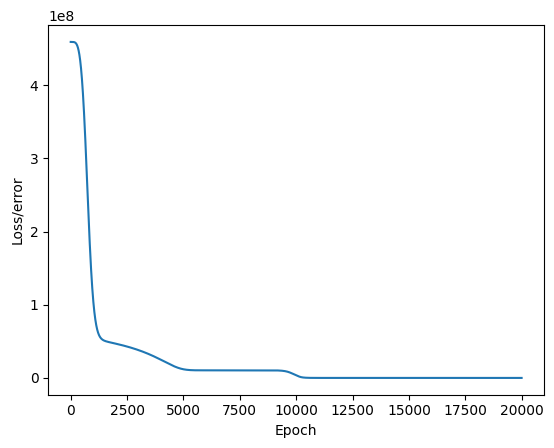

In [102]:
#Plot Loss
plt.plot(range(epochs), losses)
plt.ylabel('Loss/error')
plt.xlabel('Epoch')

In [103]:
#Evaluate Model on Test Data Set
with torch.no_grad(): #turns off backpropagation
  y_eval = model.forward(X_test)
  loss = criterion(y_eval, y_test)

loss

tensor(0.3238)

In [104]:
# Set the model to evaluation mode
model.eval()

# Disable gradient calculation
with torch.no_grad():
    # Get predictions
    y_preds = model(X_test)

    # Calculate Mean Absolute Error (MAE)
    mae = torch.mean(torch.abs(y_preds - y_test))
    print(f'MAE: {mae.item():.4f}')

    # Calculate Mean Squared Error (MSE)
    mse = torch.mean((y_preds - y_test) ** 2)
    print(f'MSE: {mse.item():.4f}')

    # Calculate R-squared
    ss_total = torch.sum((y_test - torch.mean(y_test)) ** 2)
    ss_residual = torch.sum((y_test - y_preds) ** 2)
    r_squared = 1 - (ss_residual / ss_total)
    print(f'R-squared: {r_squared.item():.4f}')


MAE: 0.1561
MSE: 0.3238
R-squared: 1.0000


In [105]:
#new random input
new_test = torch.tensor([[0.100000000000000,	3.32094820000000e-33,	-2.19433500000000e-33,	5.33289800000000e-33,	0.100000000000000,	3.32094820000000e-33,	-2.19433500000000e-33,	5.33289800000000e-33]])
#Feed into the NN, like the X_test
with torch.no_grad():
  print(model(new_test))

tensor([[ 18429.6426,  -8814.1982,   5609.0415, -15224.4873,  18429.5781,
           5609.0029,  -8814.1318, -15224.4492]])


In [106]:
# Extracting all weights and biases
for name, param in model.named_parameters():
    if param.requires_grad:  # Only if you want trainable parameters
        print(f'Layer: {name}, Weights: {param.data.numpy()}')


Layer: fc1.weight, Weights: [[ 7.13799000e+00  2.93452114e-01 -8.28278288e-02  3.24778140e-01
   2.55864429e+00  7.13437796e-02 -1.72129244e-01  2.07635775e-01]
 [ 5.08696699e+00 -2.59376705e-01  3.07307243e-01  6.61708042e-02
   5.41656303e+00  4.78819385e-02  1.70479238e-01 -4.99185584e-02]
 [ 7.15642405e+00  5.22583388e-02 -1.65052831e-01  9.01201591e-02
   2.75093699e+00 -4.14622128e-02 -1.43598646e-01  2.34537050e-01]
 [ 2.29893374e+00 -1.62991762e-01 -9.98345464e-02 -2.12581918e-01
   6.70015526e+00 -3.49197298e-01  3.19297284e-01 -3.00332367e-01]
 [ 2.72952884e-01  5.88380545e-02 -1.14800386e-01  2.18478307e-01
   5.51015660e-02  2.85658181e-01  3.86503451e-02 -1.11501254e-01]
 [ 2.73819423e+00 -9.58764106e-02  1.48795605e-01  3.15660298e-01
   6.64672518e+00 -1.54563829e-01  2.04093874e-01  6.32599741e-02]
 [ 1.79546788e-01 -2.15492576e-01 -3.49985480e-01 -1.36599079e-01
  -2.71183521e-01  2.90104300e-01  1.01834454e-01  1.46446601e-01]
 [ 1.11815207e-01 -6.15040539e-03  2.7669

In [107]:
# Access weights directly from each layer
weights_fc1 = model.fc1.weight.data.numpy()
weights_fc2 = model.fc2.weight.data.numpy()
weights_fc3 = model.fc3.weight.data.numpy()
weights_out = model.out.weight.data.numpy()

print("Weights from fc1:", weights_fc1)
print("Weights from fc2:", weights_fc2)
print("Weights from fc3:", weights_fc3)
print("Weights from output layer:", weights_out)

Weights from fc1: [[ 7.13799000e+00  2.93452114e-01 -8.28278288e-02  3.24778140e-01
   2.55864429e+00  7.13437796e-02 -1.72129244e-01  2.07635775e-01]
 [ 5.08696699e+00 -2.59376705e-01  3.07307243e-01  6.61708042e-02
   5.41656303e+00  4.78819385e-02  1.70479238e-01 -4.99185584e-02]
 [ 7.15642405e+00  5.22583388e-02 -1.65052831e-01  9.01201591e-02
   2.75093699e+00 -4.14622128e-02 -1.43598646e-01  2.34537050e-01]
 [ 2.29893374e+00 -1.62991762e-01 -9.98345464e-02 -2.12581918e-01
   6.70015526e+00 -3.49197298e-01  3.19297284e-01 -3.00332367e-01]
 [ 2.72952884e-01  5.88380545e-02 -1.14800386e-01  2.18478307e-01
   5.51015660e-02  2.85658181e-01  3.86503451e-02 -1.11501254e-01]
 [ 2.73819423e+00 -9.58764106e-02  1.48795605e-01  3.15660298e-01
   6.64672518e+00 -1.54563829e-01  2.04093874e-01  6.32599741e-02]
 [ 1.79546788e-01 -2.15492576e-01 -3.49985480e-01 -1.36599079e-01
  -2.71183521e-01  2.90104300e-01  1.01834454e-01  1.46446601e-01]
 [ 1.11815207e-01 -6.15040539e-03  2.76693791e-01 -

In [108]:
# Access biases directly from each layer
bias_fc1 = model.fc1.bias.data.numpy()
bias_fc2 = model.fc2.bias.data.numpy()
bias_fc3 = model.fc3.bias.data.numpy()
bias_out = model.out.bias.data.numpy()

print("Biases from fc1:", bias_fc1)
print("Biases from fc2:", bias_fc2)
print("Biases from fc3:", bias_fc3)
print("Biases from output layer:", bias_out)


Biases from fc1: [ 3.8786497e-05  1.4309008e-05  6.4180779e-01  1.0369475e-02
 -2.9938793e-01 -2.5327681e-04 -9.7278379e-02 -1.3552622e-01
 -2.9347423e-01 -3.5148886e-01  3.1471282e-02 -7.7231571e-02
  3.5665187e-05 -2.9014835e-01  4.3417272e-01 -2.5952718e-01]
Biases from fc2: [-0.09528138 -0.17410068 -0.07219873  1.1295809   1.7185057   5.781776
 -0.24569786 -0.51089257  3.7203805  -0.02110794  1.1372557   2.3044636
  4.0693426  -0.19790512  0.97121483  5.0502872  -0.4915243   3.3212163
 -0.1817936  -0.5810029  -0.05574957 -0.05337861 -0.22722742 -0.03935358
  0.6551958  -0.41317335 -2.197992    0.03228332 -0.08016109 -0.21913294
 -0.21698865  0.19034353]
Biases from fc3: [-4.525517    1.3023331  -1.1039538  -3.1100628   4.0185323  -0.30739102
  0.9708151  -0.0102109  -0.2208371   1.003181   -0.14651941 -0.3037141
  1.1275194   1.0760226  -0.11900585  0.27802196]
Biases from output layer: [ 0.00354154  1.9190094  -1.877273    0.38969928  0.35126707  1.7608881
 -1.8018702  -1.062042  